# Machine Learning Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("data/ML_ready.csv")

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE

2024-01-16 13:38:20.502714: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
# Create array to store results of accuracy in:
models_accuracy = {}

## Neural Network (TensorFlow)

Create split of a training data so that we can both train the model but also validate it's performance.

In [5]:
X = df.drop('Credit_Score', axis=1).values
y = df['Credit_Score'].values

y = to_categorical(y, num_classes=3) # format [0,0,1]

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=101)

Let's scale the data

In [6]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data) # fit with training data and transform training data in one step
test_data  = scaler.transform(test_data)
train_data.shape

(73920, 39)

Creating the initial model with one hidden layer.

In [7]:
model_1 = Sequential()
model_1.add(Dense(37, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(Dense(18, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(Dense(3, activation="softmax")) # use softmax to return the most probable category
model_1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor="val_accuracy",mode="max",verbose=1, patience=25) # try maximise the accuracy

2024-01-16 13:38:24.876445: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-01-16 13:38:24.883465: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-01-16 13:38:24.933948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-16 13:38:24.934553: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.645GHz coreCount: 16 deviceMemorySize: 7.92GiB deviceMemoryBandwidth: 238.66GiB/s
2024-01-16 13:38:24.934729: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-01-16 13:38:24.978810: I tensorflow/stream_executor/platform/de

In [8]:
model_1.fit(train_data, train_labels,
            epochs = 500,
            batch_size = 512,
            validation_data = (test_data, test_labels),
            verbose = 1,
            callbacks = [early_stop])

2024-01-16 13:38:27.887117: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-01-16 13:38:27.889788: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/500


2024-01-16 13:38:29.528119: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


145/145 [==============================] - 4s 16ms/step - loss: 1.0452 - accuracy: 0.4011 - val_loss: 0.8304 - val_accuracy: 0.5791
Epoch 2/500
145/145 [==============================] - 1s 8ms/step - loss: 0.8485 - accuracy: 0.5800 - val_loss: 0.7983 - val_accuracy: 0.6116
Epoch 3/500
145/145 [==============================] - 1s 8ms/step - loss: 0.8201 - accuracy: 0.6019 - val_loss: 0.7778 - val_accuracy: 0.6331
Epoch 4/500
145/145 [==============================] - 1s 8ms/step - loss: 0.8004 - accuracy: 0.6216 - val_loss: 0.7612 - val_accuracy: 0.6527
Epoch 5/500
145/145 [==============================] - 1s 8ms/step - loss: 0.7824 - accuracy: 0.6355 - val_loss: 0.7506 - val_accuracy: 0.6606
Epoch 6/500
145/145 [==============================] - 1s 8ms/step - loss: 0.7739 - accuracy: 0.6455 - val_loss: 0.7446 - val_accuracy: 0.6652
Epoch 7/500
145/145 [==============================] - 1s 6ms/step - loss: 0.7625 - accuracy: 0.6514 - val_loss: 0.7413 - val_accuracy: 0.6667
Epoch 8/50

In [9]:
model_1.save('models/credit_score_1.keras')

<AxesSubplot: >

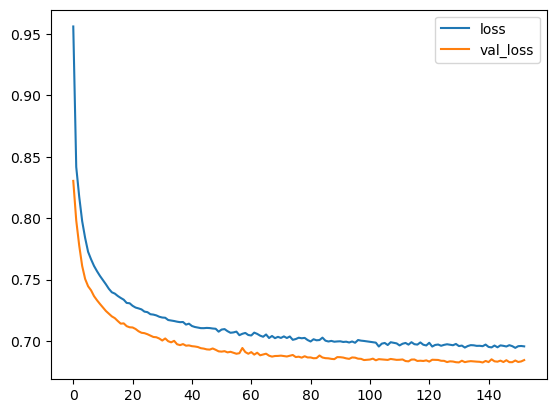

In [10]:
model_loss = pd.DataFrame(model_1.history.history)
model_loss[['loss', 'val_loss']].plot()

<AxesSubplot: >

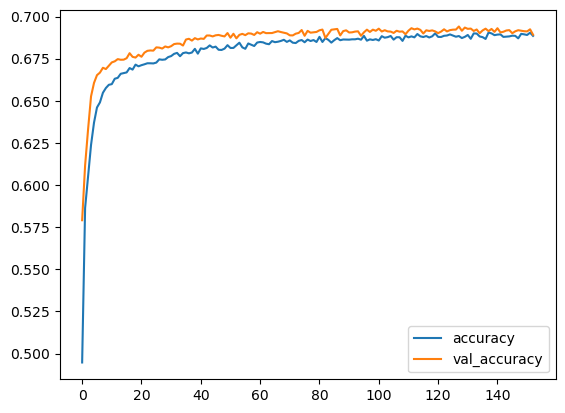

In [11]:
model_loss = pd.DataFrame(model_1.history.history)
model_loss[['accuracy', 'val_accuracy']].plot()

Getting around 69% accuracy at the looks of things...Let's try the test data

In [12]:
results = model_1.evaluate(test_data, test_labels)
print("loss = ", results[0], " with accuracy = ", results[1])
models_accuracy["Neural Network"] = results[1]


  1/578 [..............................] - ETA: 34s - loss: 0.8339 - accuracy: 0.6250

578/578 [==============================] - 3s 5ms/step - loss: 0.6845 - accuracy: 0.6892
loss =  0.6845329999923706  with accuracy =  0.6892315745353699


Text(0.5, 1.0, 'Confusion Matrix')

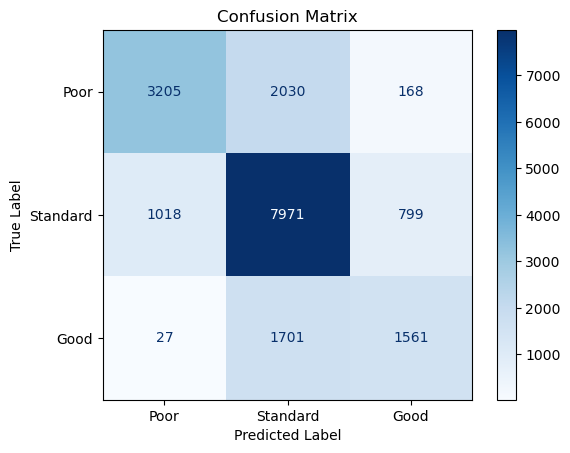

In [13]:
# Predict the values from validation dataset, predict gives probabilities, we use argmax to find the most probable
predicted_labels = np.argmax(model_1.predict(test_data), axis=1)

# Convert test labels [1, 0, 0] -> 0, [0, 1, 0] -> 1, [0, 0, 1] -> 2
true_labels = np.argmax(test_labels, axis=1)

# Compute and plot the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Poor', 'Standard', 'Good'])
disp.plot(cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

In [14]:
print(classification_report(true_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.75      0.59      0.66      5403
           1       0.68      0.81      0.74      9788
           2       0.62      0.47      0.54      3289

    accuracy                           0.69     18480
   macro avg       0.68      0.63      0.65     18480
weighted avg       0.69      0.69      0.68     18480



We see we are very good at predicting the "Standard" label and then reasonable at predicting the "Poor" label. I think we are effected by the imbalanced credit scores.

I'm also a little confused because I expected us to be very good at predicting the "Good" class and then the "Standard" class just because of the imbalanced datasets...Maybe I've made a mistake in relabelling these at the end?

## SMOTE

In [15]:
X = df.drop('Credit_Score', axis=1).values
y = df['Credit_Score'].values

print(np.unique(y, return_counts=True))

smote = SMOTE() # Synthetic Minority Oversampling TEchnique
X, y = smote.fit_resample(X,y)

print(np.unique(y, return_counts=True))

y = to_categorical(y, num_classes=3) # format [0,0,1]

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=101)

(array([0, 1, 2]), array([26773, 49182, 16445]))


(array([0, 1, 2]), array([49182, 49182, 49182]))


Can see the SMOTE function has sythentically brought all categories up to the same level matching Category 1 (Standard credit_score)

In [16]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data) # fit with training data and transform training data in one step
test_data  = scaler.transform(test_data)
train_data.shape

(118036, 39)

In [17]:
model_2 = Sequential()
model_2.add(Dense(37, activation="relu"))
model_2.add(Dropout(0.2))
model_2.add(Dense(18, activation="relu"))
model_2.add(Dropout(0.2))
model_2.add(Dense(3, activation="softmax")) # use softmax to return the most probable category
model_2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor="val_accuracy",mode="max",verbose=1, patience=25) # try maximise the accuracy

In [18]:
model_2.fit(train_data, train_labels,
            epochs = 500,
            batch_size = 512,
            validation_data = (test_data, test_labels),
            verbose = 1,
            callbacks = [early_stop])

Epoch 1/500


231/231 [==============================] - 5s 12ms/step - loss: 0.9674 - accuracy: 0.5384 - val_loss: 0.8100 - val_accuracy: 0.6715
Epoch 2/500
231/231 [==============================] - 2s 9ms/step - loss: 0.8188 - accuracy: 0.6648 - val_loss: 0.7760 - val_accuracy: 0.6829
Epoch 3/500
231/231 [==============================] - 2s 8ms/step - loss: 0.7928 - accuracy: 0.6766 - val_loss: 0.7618 - val_accuracy: 0.6856
Epoch 4/500
231/231 [==============================] - 2s 9ms/step - loss: 0.7758 - accuracy: 0.6832 - val_loss: 0.7486 - val_accuracy: 0.6918
Epoch 5/500
231/231 [==============================] - 2s 8ms/step - loss: 0.7672 - accuracy: 0.6848 - val_loss: 0.7414 - val_accuracy: 0.6945
Epoch 6/500
231/231 [==============================] - 2s 9ms/step - loss: 0.7560 - accuracy: 0.6891 - val_loss: 0.7312 - val_accuracy: 0.6972
Epoch 7/500
231/231 [==============================] - 2s 7ms/step - loss: 0.7440 - accuracy: 0.6927 - val_loss: 0.7211 - val_accuracy: 0.7007
Epoch 8/50

In [19]:
model_2.save('models/credit_score_SMOTE.keras')

<AxesSubplot: >

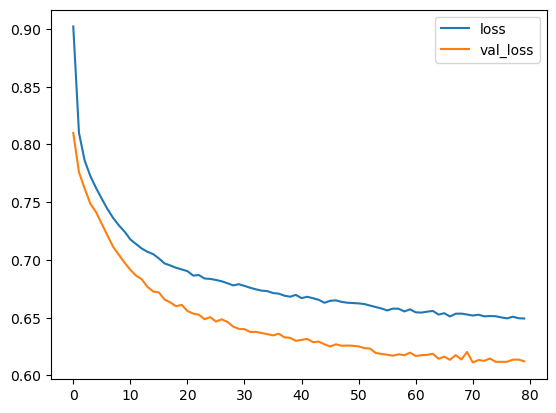

In [20]:
model_loss = pd.DataFrame(model_2.history.history)
model_loss[['loss', 'val_loss']].plot()

<AxesSubplot: >

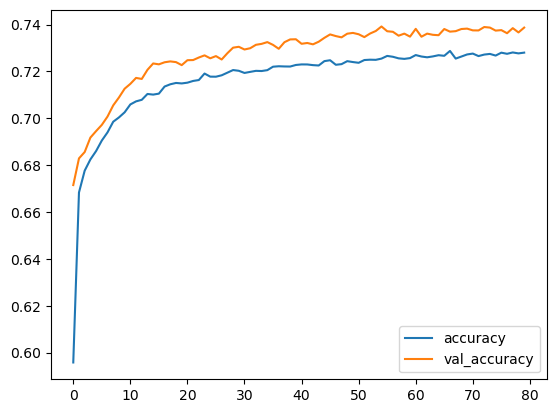

In [21]:
model_loss = pd.DataFrame(model_2.history.history)
model_loss[['accuracy', 'val_accuracy']].plot()

In [22]:
results = model_2.evaluate(test_data, test_labels)
print("loss = ", results[0], " with accuracy = ", results[1])
models_accuracy["Neural Network (SMOTE)"] = results[1]

  1/923 [..............................] - ETA: 1:18 - loss: 0.4188 - accuracy: 0.8750

923/923 [==============================] - 6s 7ms/step - loss: 0.6123 - accuracy: 0.7387
loss =  0.6122613549232483  with accuracy =  0.738732635974884


An improvement from 69% before up to 74% just by correcting for the imbalanced dataset!

Text(0.5, 1.0, 'Confusion Matrix')

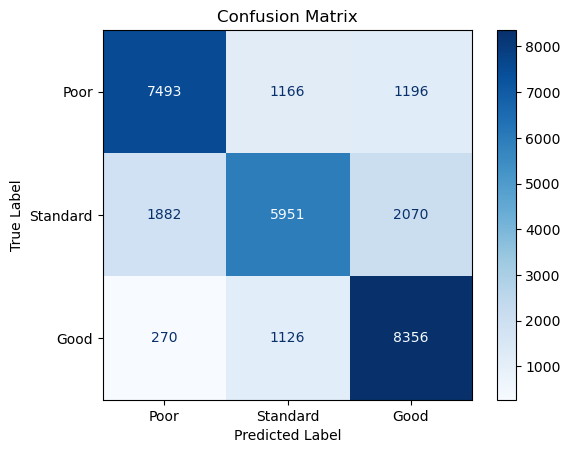

In [23]:
# Predict the values from validation dataset, predict gives probabilities, we use argmax to find the most probable
predicted_labels = np.argmax(model_2.predict(test_data), axis=1)

# Convert test labels [1, 0, 0] -> 0, [0, 1, 0] -> 1, [0, 0, 1] -> 2
true_labels = np.argmax(test_labels, axis=1)

# Compute and plot the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Poor', 'Standard', 'Good'])
disp.plot(cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

Much better representation of what I expected to see. I do note that if we predict the good label and it is not actually good, then there is an equal probability of "Standard" or "Poor" being the true label, this is something definitely to be cautious of as we would not want to predict a good credit_score and give someone a loan with low interest rate when we might not get the money back!

In [24]:
print(classification_report(true_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      9855
           1       0.72      0.60      0.66      9903
           2       0.72      0.86      0.78      9752

    accuracy                           0.74     29510
   macro avg       0.74      0.74      0.74     29510
weighted avg       0.74      0.74      0.74     29510



## Scikit Learn

### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
# Reset all data
X = df.drop('Credit_Score', axis=1).values
y = df['Credit_Score'].values
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=101)

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data) # fit with training data and transform training data in one step
test_data  = scaler.transform(test_data)
train_data.shape

(73920, 39)

In [27]:
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(train_data, train_labels) 

LogisticRegression(max_iter=1000)

In [28]:
predicted_labels = logmodel.predict(test_data)

Text(0.5, 1.0, 'Confusion Matrix')

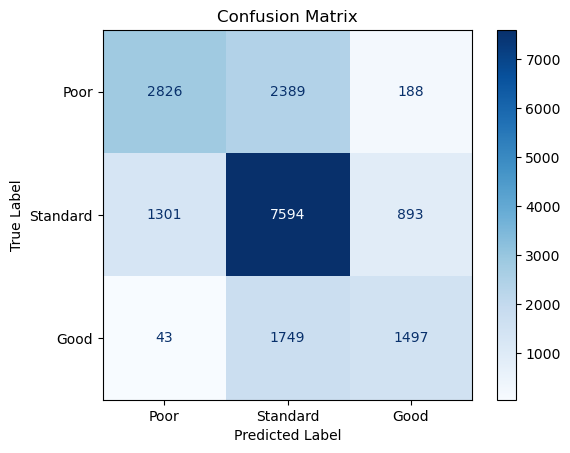

In [29]:
# Compute and plot the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Poor', 'Standard', 'Good'])
disp.plot(cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

In [30]:
print(classification_report(test_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.68      0.52      0.59      5403
           1       0.65      0.78      0.71      9788
           2       0.58      0.46      0.51      3289

    accuracy                           0.64     18480
   macro avg       0.64      0.58      0.60     18480
weighted avg       0.64      0.64      0.64     18480



In [31]:
models_accuracy["Logistic Regression"] = classification_report(test_labels, predicted_labels, output_dict=True)['accuracy']

Only 64% accuracy but we'll see if the SMOTE improves things again

In [32]:
# Reset all data
X = df.drop('Credit_Score', axis=1).values
y = df['Credit_Score'].values
smote = SMOTE() # Synthetic Minority Oversampling TEchnique
X, y = smote.fit_resample(X,y)
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=101)

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data) # fit with training data and transform training data in one step
test_data  = scaler.transform(test_data)
train_data.shape

(118036, 39)

In [33]:
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(train_data, train_labels) 

LogisticRegression(max_iter=1000)

In [34]:
predicted_labels = logmodel.predict(test_data)

Text(0.5, 1.0, 'Confusion Matrix')

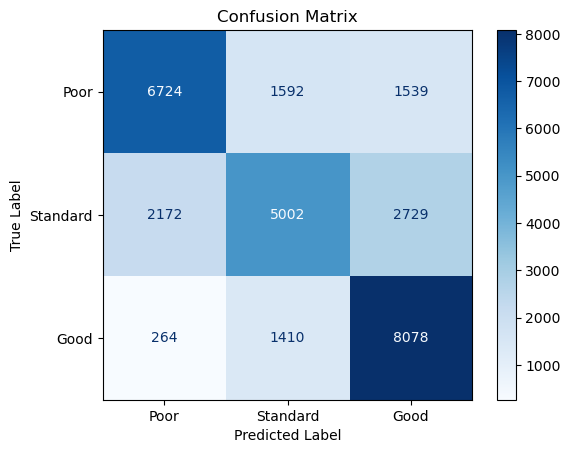

In [35]:
# Compute and plot the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Poor', 'Standard', 'Good'])
disp.plot(cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

In [36]:
print(classification_report(test_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.73      0.68      0.71      9855
           1       0.62      0.51      0.56      9903
           2       0.65      0.83      0.73      9752

    accuracy                           0.67     29510
   macro avg       0.67      0.67      0.67     29510
weighted avg       0.67      0.67      0.67     29510



In [37]:
models_accuracy["Logistic Regression (SMOTE)"] = classification_report(test_labels, predicted_labels, output_dict=True)['accuracy']

Up to 67% now so let's just keep using SMOTE by default

## K-Nearest Neighbours

In [38]:
from sklearn.neighbors import KNeighborsClassifier

Originally tested the algorithm with 1-50 nearest neighbours but later found this was excessive. Changed to lower value to speed up execution.

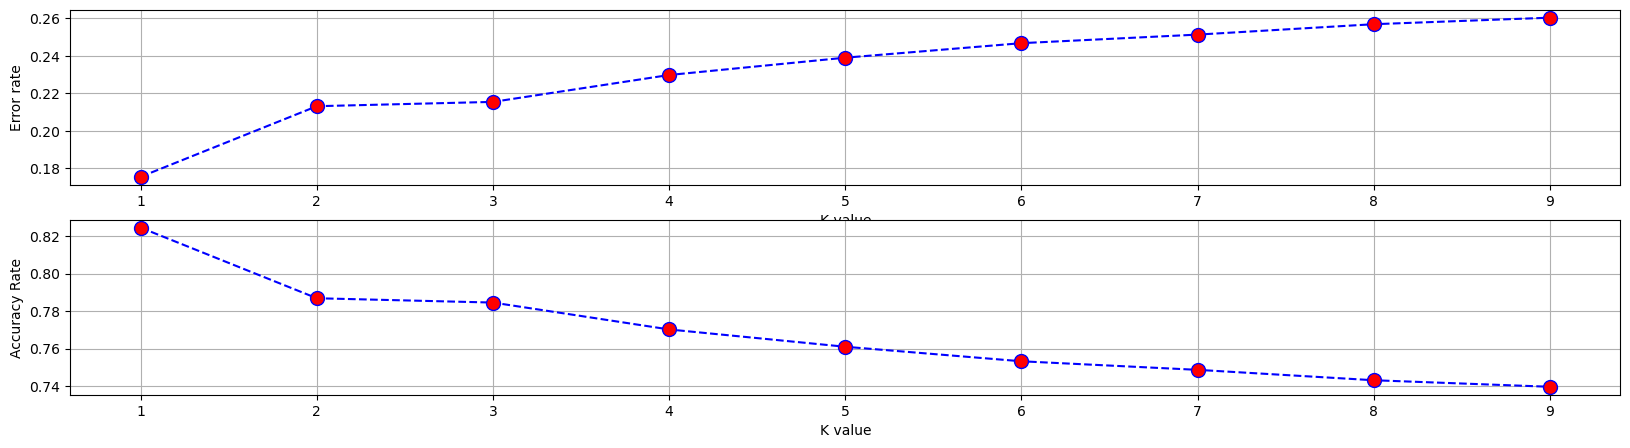

In [39]:
error_rate = []
knn_accuracy_rate = []
for nNeighbours in range(1,10): 
  knn = KNeighborsClassifier(nNeighbours)
  knn.fit(train_data, train_labels)
  predicted_labels = knn.predict(test_data)
  error_rate.append(np.mean(predicted_labels != test_labels))
  knn_accuracy_rate.append(classification_report(test_labels, predicted_labels, output_dict=True)['accuracy'])
  
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(2,1,1)
ax.plot(range(1,10), error_rate, 'b--', markerfacecolor='red', marker='o', ms=10)
ax.set_xlabel("K value")
ax.set_ylabel("Error rate")
plt.grid()

ax = fig.add_subplot(2,1,2)
ax.plot(range(1,10), knn_accuracy_rate, 'b--', markerfacecolor='red', marker='o', ms=10)
ax.set_xlabel("K value")
ax.set_ylabel("Accuracy Rate")
plt.grid()

Moving forward we choose only 1 nearest neighbour

In [40]:
knn = KNeighborsClassifier(1)
knn.fit(train_data, train_labels)
predicted_labels = knn.predict(test_data)

Text(0.5, 1.0, 'Confusion Matrix')

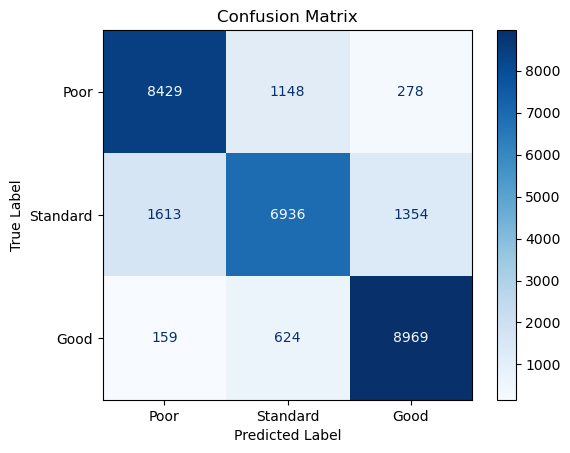

In [41]:
# Compute and plot the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Poor', 'Standard', 'Good'])
disp.plot(cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

In [42]:
print(classification_report(test_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      9855
           1       0.80      0.70      0.75      9903
           2       0.85      0.92      0.88      9752

    accuracy                           0.82     29510
   macro avg       0.82      0.83      0.82     29510
weighted avg       0.82      0.82      0.82     29510



In [43]:
models_accuracy["KNN (SMOTE)"] = classification_report(test_labels, predicted_labels, output_dict=True)['accuracy']

Very impressive 82% accuracy when we look for the nearest neighbour!

## SVM
Commented out as takes ~30 mins to train model. Accuracy was 74%.

In [44]:
#from sklearn.svm import SVC

In [45]:
#svm = SVC()
#svm.fit(train_data, train_labels)
#predicted_labels = svm.predict(test_data)

In [46]:
## Compute and plot the confusion matrix
#cm = confusion_matrix(test_labels, predicted_labels)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                              display_labels=['Poor', 'Standard', 'Good'])
#disp.plot(cmap='Blues')
#plt.xlabel("Predicted Label")
#plt.ylabel("True Label")
#plt.title("Confusion Matrix")

In [47]:
#print(classification_report(test_labels,predicted_labels))

In [48]:
#models_accuracy["SVM (SMOTE)"] = classification_report(test_labels, predicted_labels, output_dict=True)['accuracy']

Only 74% accurate.

## Decision Tree

In [49]:
from sklearn.tree import DecisionTreeClassifier

In [50]:
dtree = DecisionTreeClassifier()
dtree.fit(train_data, train_labels)
predicted_labels = dtree.predict(test_data)

Text(0.5, 1.0, 'Confusion Matrix')

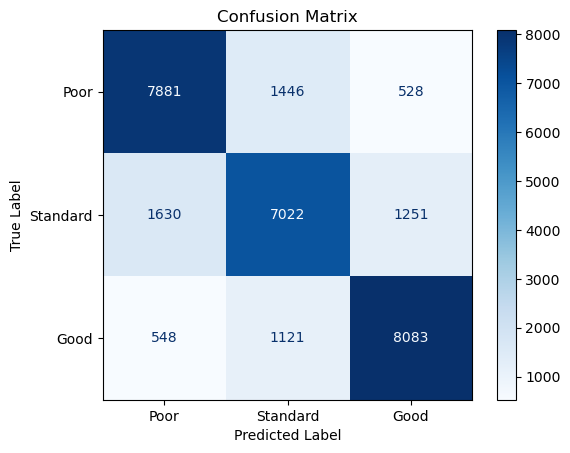

In [51]:
# Compute and plot the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Poor', 'Standard', 'Good'])
disp.plot(cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

In [52]:
print(classification_report(test_labels,predicted_labels))
models_accuracy["Decision Tree (SMOTE)"] = classification_report(test_labels, predicted_labels, output_dict=True)['accuracy']

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      9855
           1       0.73      0.71      0.72      9903
           2       0.82      0.83      0.82      9752

    accuracy                           0.78     29510
   macro avg       0.78      0.78      0.78     29510
weighted avg       0.78      0.78      0.78     29510



78% accuracy. Suprisingly good for such quick training! Does a random forest improve things?

## Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
rfc = RandomForestClassifier(n_estimators=100) # could play around with the number of trees here
rfc.fit(train_data, train_labels)
predicted_labels = rfc.predict(test_data)

Text(0.5, 1.0, 'Confusion Matrix')

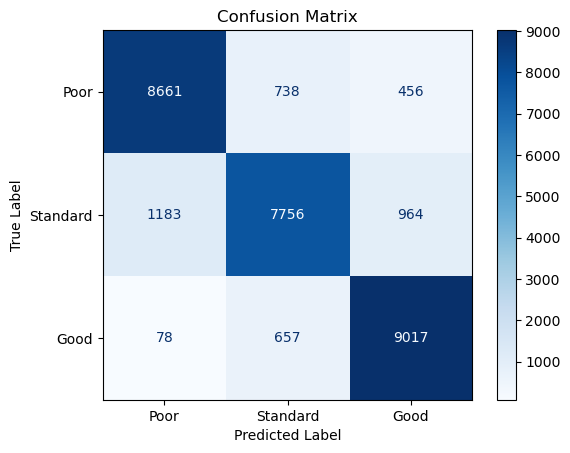

In [55]:
# Compute and plot the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Poor', 'Standard', 'Good'])
disp.plot(cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

In [56]:
print(classification_report(test_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      9855
           1       0.85      0.78      0.81      9903
           2       0.86      0.92      0.89      9752

    accuracy                           0.86     29510
   macro avg       0.86      0.86      0.86     29510
weighted avg       0.86      0.86      0.86     29510



86% accuracy is a new best! Can we optimise the number of trees though...

Tested 100-1000 in steps of 100 but found little improvement from increasing the trees so reduced the scan to speed up execution time.

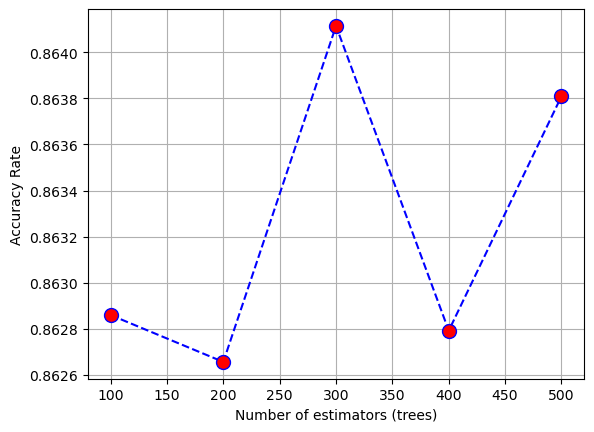

In [57]:
rfc_accuracy_rate = []
for n_estimators in range(100, 600, 100):
  rfc = RandomForestClassifier(n_estimators=n_estimators)
  rfc.fit(train_data, train_labels)
  predicted_labels = rfc.predict(test_data)
  rfc_accuracy_rate.append(classification_report(test_labels, predicted_labels, output_dict=True)['accuracy'])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(100,600, 100), rfc_accuracy_rate, 'b--', markerfacecolor='red', marker='o', ms=10)
ax.set_xlabel("Number of estimators (trees)")
ax.set_ylabel("Accuracy Rate")
plt.grid()

I mean very marginal gain but for a very long increased training time...

In [58]:
rfc = RandomForestClassifier(n_estimators=300)
rfc.fit(train_data, train_labels)
predicted_labels = rfc.predict(test_data)
models_accuracy["Random Forest (SMOTE)"] = classification_report(test_labels, predicted_labels, output_dict=True)['accuracy']

## Hist Gradient Boosting Classifier

In [59]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgbc = HistGradientBoostingClassifier() 
hgbc.fit(train_data, train_labels)
predicted_labels = hgbc.predict(test_data)


Text(0.5, 1.0, 'Confusion Matrix')

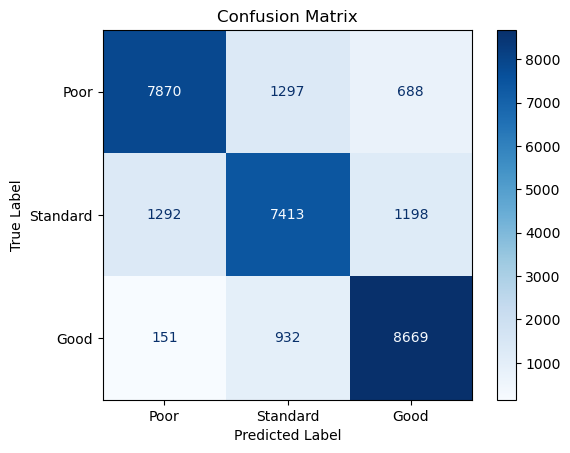

In [60]:
# Compute and plot the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Poor', 'Standard', 'Good'])
disp.plot(cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

In [61]:
print(classification_report(test_labels,predicted_labels))
models_accuracy["HistGradientBoostingClassifier (SMOTE)"] = classification_report(test_labels, predicted_labels, output_dict=True)['accuracy']

              precision    recall  f1-score   support

           0       0.85      0.80      0.82      9855
           1       0.77      0.75      0.76      9903
           2       0.82      0.89      0.85      9752

    accuracy                           0.81     29510
   macro avg       0.81      0.81      0.81     29510
weighted avg       0.81      0.81      0.81     29510



## Gridsearch Random Forest Classifier

In [62]:
#from sklearn.model_selection import GridSearchCV

## Already tested number of estimators so let's just test max features
#param_grid = {'n_estimators': [50, 500], 
#              'max_features': ["sqrt", "log2", 10, 20, 30]} 
#grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=3)
#grid.fit(train_data,train_labels)

# Results

Order dictionary with most accurate at the top

In [63]:
models_accuracy = {k: v for k, v in sorted(models_accuracy.items(), key=lambda item: item[1], reverse=True)}

In [64]:
print("{:<40} {:^10}".format('Method','Accuracy'))
for method, accuracy in models_accuracy.items():
  print("{:<40} {:^10.2%}".format(method, accuracy))

Method                                    Accuracy 
Random Forest (SMOTE)                      86.37%  
KNN (SMOTE)                                82.46%  
HistGradientBoostingClassifier (SMOTE)     81.17%  
Decision Tree (SMOTE)                      77.89%  
Neural Network (SMOTE)                     73.87%  
Neural Network                             68.92%  
Logistic Regression (SMOTE)                67.11%  
Logistic Regression                        64.49%  


## After further feature engineering

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("data/ML_ready_updated.csv")

In [3]:
X = df.drop('Credit_Score', axis=1).values
y = df['Credit_Score'].values

smote = SMOTE() # Synthetic Minority Oversampling TEchnique
X, y = smote.fit_resample(X,y)

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=101)

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data) # fit with training data and transform training data in one step
test_data  = scaler.transform(test_data)

In [4]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=300)
rfc.fit(train_data, train_labels)
predicted_labels = rfc.predict(test_data)
print(classification_report(test_labels, predicted_labels))


              precision    recall  f1-score   support

           0       0.88      0.89      0.88      9855
           1       0.86      0.79      0.82      9903
           2       0.87      0.93      0.90      9752

    accuracy                           0.87     29510
   macro avg       0.87      0.87      0.87     29510
weighted avg       0.87      0.87      0.87     29510



Currently 87% after changing my classification of the age and incorporating the Type_of_Loan column